Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

Define a class for AddGaussianNoise

In [2]:
# Define a class AddGaussianNoise
class AddGaussianNoise(object):
    # Initialize the AddGaussianNoise object with mean and standard deviation values
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    # Add Gaussian noise to the input tensor
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    # Return a string representation of the AddGaussianNoise object
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Define a transform to convert images to tensors and add gaussian noise

In [3]:
# Define a transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

trans = transforms.ToTensor()

Load Training Data

In [4]:
# Load the MNIST dataset with gaussian noise
mnist_data_gauss = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=trans)

# Create a data loader to load the data with gaussian noise in batches
data_loader_gauss = torch.utils.data.DataLoader(dataset=mnist_data_gauss, batch_size=64, shuffle=False)
# Create a data loader to load the data in batches
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=False)

dataiter = iter(data_loader_gauss)
images, labels = dataiter.__next__()
print(torch.min(images), torch.max(images))

100%|██████████| 9912422/9912422 [00:00<00:00, 101864052.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74636903.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27006655.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2761746.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

tensor(-4.3920) tensor(6.2198)


Definition of the Autoencoder with a Bottleneck layer of 49 neurons

In [5]:
# This is the definition of the Autoencoder model using a neural network with encoder and decoder modules.
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # N, 784
        self.encoder = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Linear(98, 49),
        )

        self.decoder = nn.Sequential(
            nn.Linear(49, 98),
            nn.ReLU(),
            nn.Linear(98, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Train the Autoencoder for n epochs

In [6]:

# These lines define the loss function (MSE loss), instantiate the Autoencoder model
# learning rate of 1e-3 and L2 regularization with a weight decay of 1e-5.
criterion = nn.MSELoss()
model = Autoencoder()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-10, momentum=0.9)

# train the model over n epochs
num_epochs = 100
outputs = []

for epoch in range(num_epochs):
    for j in range(0,500):
        rand_index = random.randint(0, 49999)
    #for (img, _) in (mnist_data_gauss):
        img, _ = mnist_data_gauss[rand_index]
        img = img.reshape(-1, 28 * 28)
        recon = model(img)
        #loss = criterion(recon, img)

        real_img, _ = mnist_data[rand_index]
        real_img = real_img.reshape(-1, 28 * 28)
        loss = criterion(recon, real_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch + 1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:0.0603
Epoch:2, Loss:0.0611
Epoch:3, Loss:0.0750
Epoch:4, Loss:0.0883
Epoch:5, Loss:0.0672
Epoch:6, Loss:0.0618
Epoch:7, Loss:0.0734
Epoch:8, Loss:0.0757
Epoch:9, Loss:0.0711
Epoch:10, Loss:0.0430
Epoch:11, Loss:0.0906
Epoch:12, Loss:0.0524
Epoch:13, Loss:0.0540
Epoch:14, Loss:0.0556
Epoch:15, Loss:0.0583
Epoch:16, Loss:0.0447
Epoch:17, Loss:0.0593
Epoch:18, Loss:0.0418
Epoch:19, Loss:0.0514
Epoch:20, Loss:0.0467
Epoch:21, Loss:0.0185
Epoch:22, Loss:0.0452
Epoch:23, Loss:0.0143
Epoch:24, Loss:0.0560
Epoch:25, Loss:0.0542
Epoch:26, Loss:0.0650
Epoch:27, Loss:0.0251
Epoch:28, Loss:0.0560
Epoch:29, Loss:0.0227
Epoch:30, Loss:0.0302
Epoch:31, Loss:0.0219
Epoch:32, Loss:0.0173
Epoch:33, Loss:0.0336
Epoch:34, Loss:0.0630
Epoch:35, Loss:0.0602
Epoch:36, Loss:0.0344
Epoch:37, Loss:0.0369
Epoch:38, Loss:0.0268
Epoch:39, Loss:0.0169
Epoch:40, Loss:0.0729
Epoch:41, Loss:0.0290
Epoch:42, Loss:0.0393
Epoch:43, Loss:0.0342
Epoch:44, Loss:0.0395
Epoch:45, Loss:0.0741
Epoch:46, Loss:0.06

Plot the reconstructed images versus the images with Gaussian noise for every 20. epoch

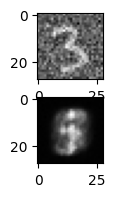

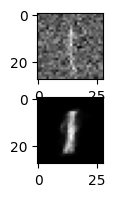

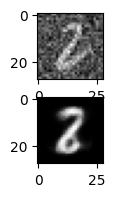

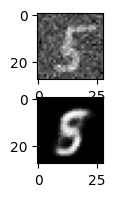

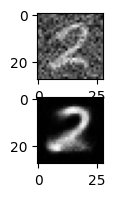

In [7]:
# Plot the resulting images
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9 + i + 1)
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

plt.show()